In [4]:
# --- SETUP ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')


# Cargar archivo .env
# Ruta relativa desde el notebook hasta el .env
dotenv_path = '../generadores/.env'  #

# Cargar el archivo .env desde la ruta especificada
load_dotenv(dotenv_path=dotenv_path)

# Leer variables de entorno
username = os.getenv("USUARIO_DB")
password = os.getenv("CLAVE_BD")

# Validar que se cargaron bien
print("Usuario:", username)
print("Contraseña cargada:", bool(password))  # No imprime la clave, pero verifica si existe

if not username or not password:
    raise ValueError("Las variables de entorno USUARIO_DB o CLAVE_BD no están definidas")

# Cadena de conexión
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=upgradeserver-vf.database.windows.net;'
    'DATABASE=Banco;'
    f'UID={username};'
    f'PWD={password};'
    'Connection Timeout=30;'
)

# Conexión
conn = pyodbc.connect(conn_str)



Usuario: vanesa
Contraseña cargada: True


In [5]:
usuarios = pd.read_sql_query("SELECT * FROM usuarios", conn)
creditos = pd.read_sql_query("SELECT * FROM creditos", conn)
activos_financieros = pd.read_sql_query("SELECT usuario_id, tipo_activo, monto FROM activos_financieros", conn)

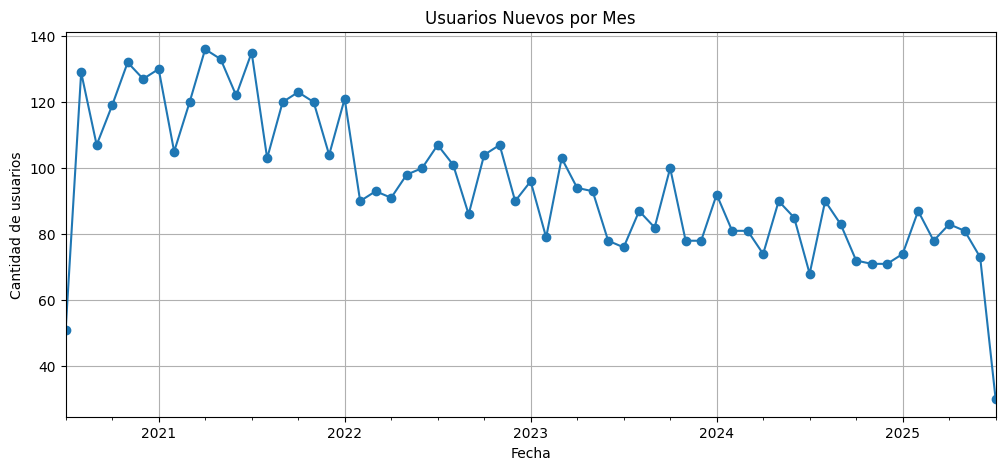

NameError: name 'LinearRegression' is not defined

In [6]:
# --- PREDICCION A 6 MESES: NUEVOS USUARIOS ---
# Usamos la fecha del primer crédito como proxy de entrada al banco
creditos['fecha_inicio'] = pd.to_datetime(creditos['fecha_inicio'])
primer_credito = creditos.sort_values('fecha_inicio').drop_duplicates('usuario_id')
usuarios_por_mes = primer_credito.groupby(primer_credito['fecha_inicio'].dt.to_period('M')).size().to_timestamp()

# Visualizar usuarios nuevos por mes
usuarios_por_mes.plot(marker='o', figsize=(12, 5), title='Usuarios Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de usuarios")
plt.xlabel("Fecha")
plt.show()

# Crear variables de regresión
df_pred = usuarios_por_mes.reset_index()
df_pred.columns = ['fecha', 'nuevos_usuarios']
df_pred['mes_num'] = np.arange(len(df_pred))

# Entrenar modelo
modelo = LinearRegression()
modelo.fit(df_pred[['mes_num']], df_pred['nuevos_usuarios'])

# Predecir próximos 6 meses
futuro = pd.DataFrame({'mes_num': np.arange(len(df_pred), len(df_pred) + 6)})
futuro['pred_usuarios'] = modelo.predict(futuro[['mes_num']])
futuro['fecha'] = pd.date_range(df_pred['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicción
print("\nPredicción de nuevos usuarios para los próximos 6 meses:")
print(futuro[['fecha', 'pred_usuarios']].round(0))

# Visualizar junto al histórico
plt.figure(figsize=(12, 5))
plt.plot(df_pred['fecha'], df_pred['nuevos_usuarios'], label='Histórico', marker='o')
plt.plot(futuro['fecha'], futuro['pred_usuarios'], label='Predicción', marker='o', linestyle='--')
plt.title("Nuevos Usuarios por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- PREDICCION A 6 MESES: NUEVOS CREDITOS ---
creditos_por_mes = creditos.groupby(creditos['fecha_inicio'].dt.to_period('M')).size().to_timestamp()

# Visualización
creditos_por_mes.plot(marker='o', figsize=(12, 5), title='Créditos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de créditos")
plt.xlabel("Fecha")
plt.show()

# Crear variables de regresión
df_creditos = creditos_por_mes.reset_index()
df_creditos.columns = ['fecha', 'nuevos_creditos']
df_creditos['mes_num'] = np.arange(len(df_creditos))

# Modelo lineal
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_creditos[['mes_num']], df_creditos['nuevos_creditos'])

# Predecir 6 meses siguientes
futuro_creditos = pd.DataFrame({'mes_num': np.arange(len(df_creditos), len(df_creditos) + 6)})
futuro_creditos['pred_creditos'] = modelo_creditos.predict(futuro_creditos[['mes_num']])
futuro_creditos['fecha'] = pd.date_range(df_creditos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

print("\nPredicción de nuevos créditos para los próximos 6 meses:")
print(futuro_creditos[['fecha', 'pred_creditos']].round(0))

# Visualización completa
plt.figure(figsize=(12, 5))
plt.plot(df_creditos['fecha'], df_creditos['nuevos_creditos'], label='Histórico', marker='o')
plt.plot(futuro_creditos['fecha'], futuro_creditos['pred_creditos'], label='Predicción', marker='o', linestyle='--')
plt.title("Créditos Nuevos por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# --- PREDICCION A 6 MESES: NUEVOS ACTIVOS FINANCIEROS, MONEDAS DIGITALES Y CUENTAS BANCARIAS ---
for tabla, nombre, titulo in [
    (activos_financieros, 'activos_financieros', 'Activos Financieros'),
    (monedas_digitales, 'monedas_digitales', 'Monedas Digitales'),
    (cuentas_bancarias, 'cuentas_bancarias', 'Cuentas Bancarias')
]:
    tabla['fecha_inicio'] = pd.to_datetime(tabla['fecha_inicio'])
    series_mensual = tabla.groupby(tabla['fecha_inicio'].dt.to_period('M')).size().to_timestamp()

    # Visualización
    series_mensual.plot(marker='o', figsize=(12, 5), title=f'{titulo} Nuevos por Mes')
    plt.grid(True)
    plt.ylabel(f"Cantidad de {nombre}")
    plt.xlabel("Fecha")
    plt.show()

    # Predicción
    df_aux = series_mensual.reset_index()
    df_aux.columns = ['fecha', 'nuevos']
    df_aux['mes_num'] = np.arange(len(df_aux))

    modelo_aux = LinearRegression()
    modelo_aux.fit(df_aux[['mes_num']], df_aux['nuevos'])

    futuro_aux = pd.DataFrame({'mes_num': np.arange(len(df_aux), len(df_aux) + 6)})
    futuro_aux['pred'] = modelo_aux.predict(futuro_aux[['mes_num']])
    futuro_aux['fecha'] = pd.date_range(df_aux['fecha'].max() + MonthEnd(1), periods=6, freq='M')

    print(f"\nPredicción de nuevos {titulo.lower()} para los próximos 6 meses:")
    print(futuro_aux[['fecha', 'pred']].round(0))

    plt.figure(figsize=(12, 5))
    plt.plot(df_aux['fecha'], df_aux['nuevos'], label='Histórico', marker='o')
    plt.plot(futuro_aux['fecha'], futuro_aux['pred'], label='Predicción', marker='o', linestyle='--')
    plt.title(f"{titulo} Nuevos por Mes (Histórico + Predicción)")
    plt.ylabel("Cantidad")
    plt.xlabel("Fecha")
    plt.legend()
    plt.grid(True)
    plt.show()

NameError: name 'monedas_digitales' is not defined

In [ ]:
# --- PREDICCION DEL MONTO TOTAL DE CREDITOS PARA EL PROXIMO MES ---
monto_mensual = creditos.groupby(creditos['fecha_inicio'].dt.to_period('M'))['monto'].sum().to_timestamp()

# Visualización
monto_mensual.plot(marker='o', figsize=(12, 5), title='Monto Total Otorgado en Créditos por Mes')
plt.grid(True)
plt.ylabel("Monto total")
plt.xlabel("Fecha")
plt.show()

# Predicción
df_monto = monto_mensual.reset_index()
df_monto.columns = ['fecha', 'monto']
df_monto['mes_num'] = np.arange(len(df_monto))

modelo_monto = LinearRegression()
modelo_monto.fit(df_monto[['mes_num']], df_monto['monto'])

futuro_monto = pd.DataFrame({'mes_num': [len(df_monto)]})  # Solo un mes adelante
futuro_monto['pred_monto'] = modelo_monto.predict(futuro_monto[['mes_num']])
futuro_monto['fecha'] = [df_monto['fecha'].max() + MonthEnd(1)]

print("\nPredicción del monto total de créditos para el próximo mes:")
print(futuro_monto[['fecha', 'pred_monto']].round(0))

plt.figure(figsize=(12, 5))
plt.plot(df_monto['fecha'], df_monto['monto'], label='Histórico', marker='o')
plt.plot(futuro_monto['fecha'], futuro_monto['pred_monto'], label='Predicción', marker='o', linestyle='--')
plt.title("Monto Total Otorgado en Créditos (Histórico + Predicción para 1 Mes)")
plt.ylabel("Monto")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# --- PREDICCION DE MOROSOS NUEVOS POR MES ---
primer_credito_morosidad = creditos.sort_values('fecha_inicio').drop_duplicates('usuario_id')
primer_credito_morosidad = primer_credito_morosidad.merge(usuarios[['usuario_id', 'moroso']], on='usuario_id')

morosos_por_mes = primer_credito_morosidad[primer_credito_morosidad['moroso'] == 1].groupby(
    primer_credito_morosidad['fecha_inicio'].dt.to_period('M')
).size().to_timestamp()

# Visualización
morosos_por_mes.plot(marker='o', figsize=(12, 5), title='Morosos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.show()

# Predicción
df_morosos = morosos_por_mes.reset_index()
df_morosos.columns = ['fecha', 'morosos']
df_morosos['mes_num'] = np.arange(len(df_morosos))

modelo_morosos = LinearRegression()
modelo_morosos.fit(df_morosos[['mes_num']], df_morosos['morosos'])

futuro_morosos = pd.DataFrame({'mes_num': np.arange(len(df_morosos), len(df_morosos) + 6)})
futuro_morosos['pred'] = modelo_morosos.predict(futuro_morosos[['mes_num']])
futuro_morosos['fecha'] = pd.date_range(df_morosos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

print("\nPredicción de morosos nuevos para los próximos 6 meses:")
print(futuro_morosos[['fecha', 'pred']].round(0))

plt.figure(figsize=(12, 5))
plt.plot(df_morosos['fecha'], df_morosos['morosos'], label='Histórico', marker='o')
plt.plot(futuro_morosos['fecha'], futuro_morosos['pred'], label='Predicción', marker='o', linestyle='--')
plt.title("Morosos Nuevos por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()
